In [20]:
import matplotlib.pyplot as plt         # Library buat bikin grafik yang bertujuan untuk memonitori perkembangan AI
import tensorflow as tf                 # Library buat bikin AI
import numpy as np                      # Library buat proses data berupa matriks/array (angka)
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
                                        # Sub-Library buat bikin bagian dalem AI, Nodes dan Layers

from PIL import Image                   # Pillow itu buat process gambar
import os                               # buat delete folder, insert data, etc
import pandas as pd                     # buat akses apapun yg berhubungan dgn csv
from tqdm import tqdm                   # untuk monitor progress dari program
import random                           # buat ngerandom data di csv

In [11]:
CATARACTS = ['cataract', 'normal']                                              # sesuai sama berapa data yang kita punya 

data = []                                                                       # bikin empty array

for i, CATARACT in enumerate(CATARACTS):                                        # di setiap array cataracts kita looping
    TEST_IMAGE_PATH = os.path.join('test', CATARACT)                            # ini ngambil file directory dari folder cataract
    PROCESSED_TEST_IMAGE_PATH = os.path.join('Processed Test Data', CATARACT)   

    if not os.path.exists(PROCESSED_TEST_IMAGE_PATH):                           # kalo foldernya gaada, nanti bikin folder baru
        os.makedirs(PROCESSED_TEST_IMAGE_PATH)

    file_names = os.listdir(TEST_IMAGE_PATH)                                    # dia bakal ngambil file name kita dari folder test

    for file_name in tqdm(file_names, unit='img', desc='Processing {:<20} images'.format(CATARACT)):    # buat ngelist progress -> pake tqdm
        image = Image.open(os.path.join(TEST_IMAGE_PATH, file_name))            # ini dia sama, ngambil gambar dari file directory
        image = image.convert('L')                                              # convert L itu artinya convert jadi 0-255 (black n white)
        image = image.resize((300, 200))                                        # resize imagenya, karena kegedean size bakal lebih lama
        image.save(os.path.join(PROCESSED_TEST_IMAGE_PATH, file_name))          # save imagenya yang udah di process ke dalam file directory
        
        binary_image = 255 - np.array(image)                                    # karena imagenya inverted, kasi 255 - arraynya
        data.append(np.insert(binary_image.flatten(), 0, i))                    # append datanya ke dalam array (yg td kosong)
                                                                                # kalo flatten brti yg tdinya 0-255 jadi 0-1
random.shuffle(data)                                                            # kita random shuffle datanya supaya
                                                                                    # ->mengurangi adanya batch size sama

Processing normal               images: 100%|██████████| 60/60 [00:01<00:00, 45.20img/s]


In [14]:
pd.DataFrame(data).to_csv('test.csv', index=False, header=False)                # bikin csv pake pandas, dan upload datanya ke dalam csv 

In [15]:
CATARACTS = ['cataract', 'normal']

data = []

for i, CATARACT in enumerate(CATARACTS):
    TRAIN_IMAGE_PATH = os.path.join('train', CATARACT)
    PROCESSED_TRAIN_IMAGE_PATH = os.path.join('Processed Train Data', CATARACT)

    if not os.path.exists(PROCESSED_TRAIN_IMAGE_PATH):
        os.makedirs(PROCESSED_TRAIN_IMAGE_PATH)

    file_names = os.listdir(TRAIN_IMAGE_PATH)

    for file_name in tqdm(file_names, unit='img', desc='Processing {:<20} images'.format(CATARACT)):
        image = Image.open(os.path.join(TRAIN_IMAGE_PATH, file_name))
        image = image.convert('L')
        image = image.resize((300, 200))
        image.save(os.path.join(PROCESSED_TRAIN_IMAGE_PATH, file_name))

        binary_image = 255 - np.array(image)
        data.append(np.insert(binary_image.flatten(), 0, i))


random.shuffle(data)

Processing normal               images: 100%|██████████| 246/246 [00:07<00:00, 33.66img/s]


In [16]:
pd.DataFrame(data).to_csv('train.csv', index=False, header=False)

In [17]:
train_csv = pd.read_csv('train.csv', header=None)                   # ambil csv dari pandas read

x_train = train_csv.values                                          # ambil setiap baris dari train.csv
y_train = np.array([temp[0] for temp in x_train], dtype=np.int32)   # nanti disini, kita ambil xtrainnya tapi kita gapake array yg index 0

x_train = [row[1:] for row in x_train]                              # ini ambil x train tapi dari index 1 sampe selesai
x_train = [row.reshape(200, 300) for row in x_train]                # kita reshape sesuai sama size pixel p(y,x)(karena tdi diubah ke csv angka)
x_train = np.array(x_train, dtype=np.uint8)                         # jadiin numpy

test_csv = pd.read_csv('test.csv', header=None)                     # lakuin hal yang sama ke dalam test.csv nya

x_test = test_csv.values
y_test = np.array([temp[0] for temp in x_test], dtype=np.int32)

x_test = [row[1:] for row in x_test]
x_test = [row.reshape(200, 300) for row in x_test]
x_test = np.array(x_test, dtype=np.uint8)

In [ ]:
x_train = tf.keras.utils.normalize(x_train, axis=1)                 # kita harus normalize buat tensorflow bisa akses data kita
x_test = tf.keras.utils.normalize(x_test, axis=1)                   # kalo ga di normalize ga bisa

In [21]:
model = tf.keras.models.Sequential()

model.add(Flatten())                                        # flatten tu ubah dari 1-255 -> 0-1
model.add(Dense(512, activation=tf.nn.relu))                # ini hidden layers
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dense(2, activation=tf.nn.softmax))

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(192, 216, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
model.summary()
model.save('CataractModel')

Epoch 1/10
16/16 [==============================] - 6s 347ms/step - loss: 3992.7134 - accuracy: 0.5071 - val_loss: 3713.7625 - val_accuracy: 0.4959
Epoch 2/10
16/16 [==============================] - 5s 337ms/step - loss: 2049.8123 - accuracy: 0.5295 - val_loss: 589.1160 - val_accuracy: 0.5785
Epoch 3/10
16/16 [==============================] - 5s 328ms/step - loss: 313.8360 - accuracy: 0.6802 - val_loss: 415.9966 - val_accuracy: 0.6281
Epoch 4/10
16/16 [==============================] - 5s 327ms/step - loss: 206.9478 - accuracy: 0.7149 - val_loss: 439.0051 - val_accuracy: 0.6116
Epoch 5/10
16/16 [==============================] - 5s 324ms/step - loss: 221.6625 - accuracy: 0.7047 - val_loss: 154.6793 - val_accuracy: 0.7521
Epoch 6/10
16/16 [==============================] - 5s 341ms/step - loss: 149.8597 - accuracy: 0.7434 - val_loss: 163.0227 - val_accuracy: 0.7934
Epoch 7/10
16/16 [==============================] - 5s 337ms/step - loss: 73.9510 - accuracy: 0.8126 - val_loss: 73.9320 

INFO:tensorflow:Assets written to: CataractModel\assets


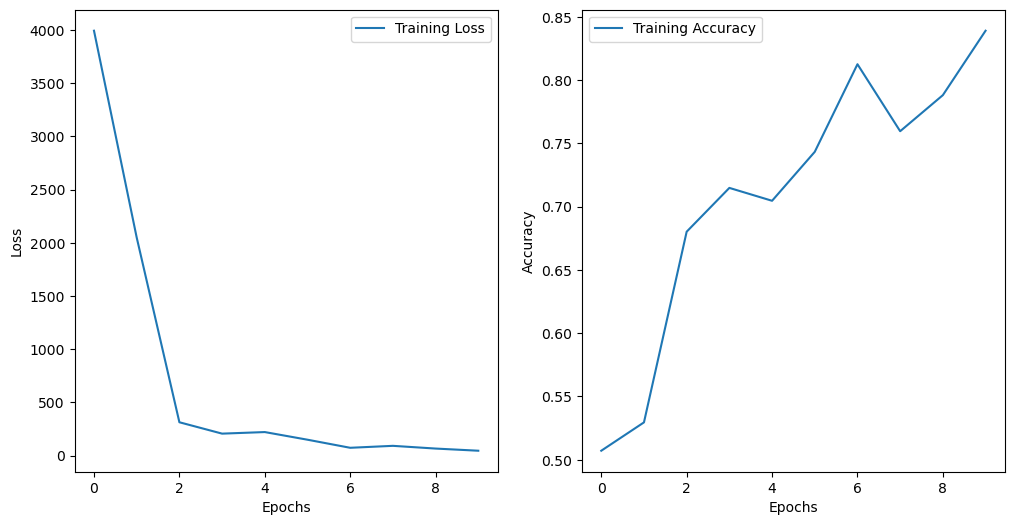

In [25]:
# Displaying Loss vs Accuracy graph

loss = history.history['loss']
accuracy = history.history['accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

4/4 [==============================] - 0s 23ms/step
Model Accuracy: 88.9%


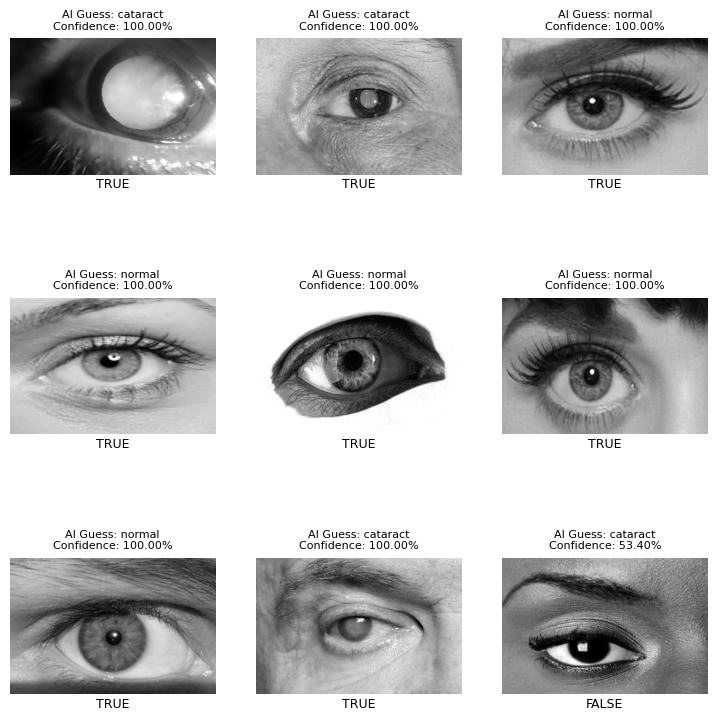

In [33]:
CATARACTS = ['cataract', 'normal']          # data kita ada berapa

num_rows = 3                                # tabel column sama row
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_rows*3, num_cols*3))          # setiap plot dibagi bagi spacenya
fig.subplots_adjust(hspace=0.5)                                                         # ksi spacing horizontal 0.5 setiap barisnya

prediction = model.predict([x_test])                                                    # ambil prediction dari model kita

successful_prediction = 0                                                               # tracking prediction mana yang success

for i in range(num_rows * num_cols):                                                    # ini looping setiap row sama column
    row = i // num_cols
    col = i % num_cols

    random_element_index = random.randint(0, len(x_test - 1))                           # ambil random element dari data length index kita

    guess = CATARACTS[np.argmax(prediction[random_element_index])]                      # guess tu ambil max dari persentase cataract/normal
    confidence = prediction[random_element_index][np.argmax(prediction[random_element_index])] * 100    # kasi confidencenya bener berapa

    axes[row, col].imshow(x_test[random_element_index], cmap=plt.cm.binary)             # show image
    axes[row, col].set_title(f"AI Guess: {guess}\nConfidence: {confidence:.2f}%", fontsize=8)        # show confidence
    axes[row, col].text(0.5, -0.1, f"{'TRUE' if np.argmax(prediction[random_element_index]) == y_test[random_element_index] else 'FALSE'}", 
                        transform=axes[row, col].transAxes, fontsize=9, ha='center')    # show text
    axes[row, col].axis('off')                                                          # axis y sama axis x diilangin buat nunjukin gambar

    if np.argmax(prediction[random_element_index]) == y_test[random_element_index]: successful_prediction += 1  
    # showing prediction, kalo bener kasi + 1

plt.savefig('Guess.jpg')
print('Model Accuracy: {:.1f}%'.format(successful_prediction / (num_cols * num_rows) * 100)) # showing model accuracy kita berapa